# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі 0.001
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [3]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [4]:
# Створимо нейронну мережу
class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer1 = DenseLayer(784, 128)
    # Другий шар, який складається з 256 нейронів
    self.layer2 = DenseLayer(128, 256)
    # Вихідний шар
    self.output_layer = DenseLayer(256, 10)


  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x = self.layer1(x, activation=0)
    x = self.layer2(x, activation=0)
    x = self.output_layer(x, activation=1)

    return x

In [5]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [6]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    trainable_variables = neural_net.trainable_variables
    # Обчислимо за ними значення градієнта
    gradients = g.gradient(loss, trainable_variables)
    # Модифікуємо параметри
    optimizer.apply_gradients(zip(gradients, trainable_variables))
      
    return loss

In [7]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    loss = train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        acc = accuracy(pred, batch_y)
        loss_history.append(loss.numpy())
        accuracy_history.append(acc.numpy())
        print(f"Step: {step}, Loss: {loss.numpy()}, Accuracy: {acc.numpy()}")


Step: 100, Loss: 351.4405517578125, Accuracy: 0.72265625
Step: 200, Loss: 308.9940185546875, Accuracy: 0.70703125
Step: 300, Loss: 194.67892456054688, Accuracy: 0.82421875
Step: 400, Loss: 164.96585083007812, Accuracy: 0.8046875
Step: 500, Loss: 123.05381774902344, Accuracy: 0.8984375
Step: 600, Loss: 116.07157135009766, Accuracy: 0.85546875
Step: 700, Loss: 111.70581817626953, Accuracy: 0.87109375
Step: 800, Loss: 84.14492797851562, Accuracy: 0.91796875
Step: 900, Loss: 143.38400268554688, Accuracy: 0.86328125
Step: 1000, Loss: 119.81007385253906, Accuracy: 0.8828125
Step: 1100, Loss: 91.02549743652344, Accuracy: 0.890625
Step: 1200, Loss: 125.42430114746094, Accuracy: 0.89453125
Step: 1300, Loss: 71.36856079101562, Accuracy: 0.921875
Step: 1400, Loss: 99.07249450683594, Accuracy: 0.8984375
Step: 1500, Loss: 132.5858154296875, Accuracy: 0.875
Step: 1600, Loss: 96.49490356445312, Accuracy: 0.90234375
Step: 1700, Loss: 81.33695220947266, Accuracy: 0.91015625
Step: 1800, Loss: 105.762931

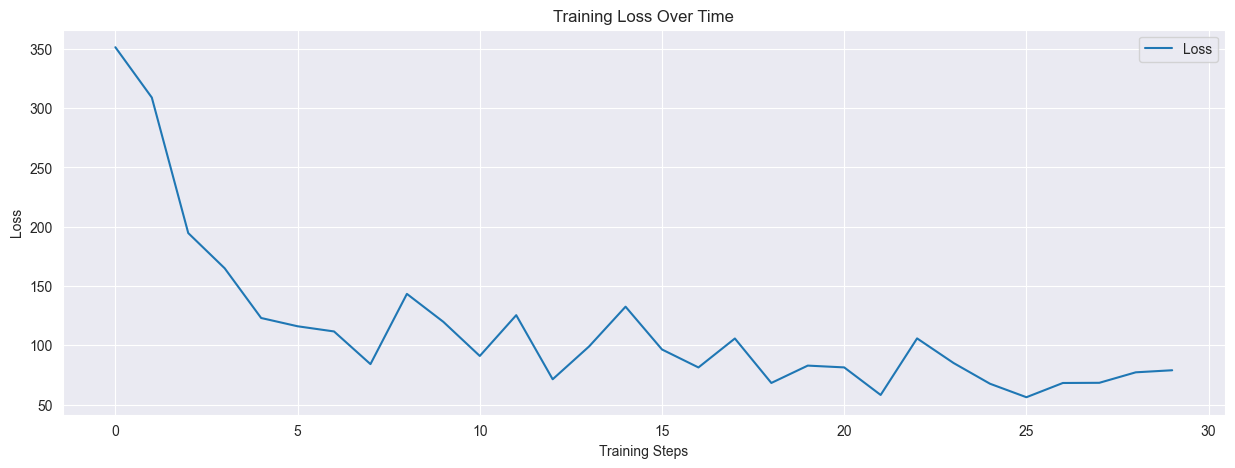

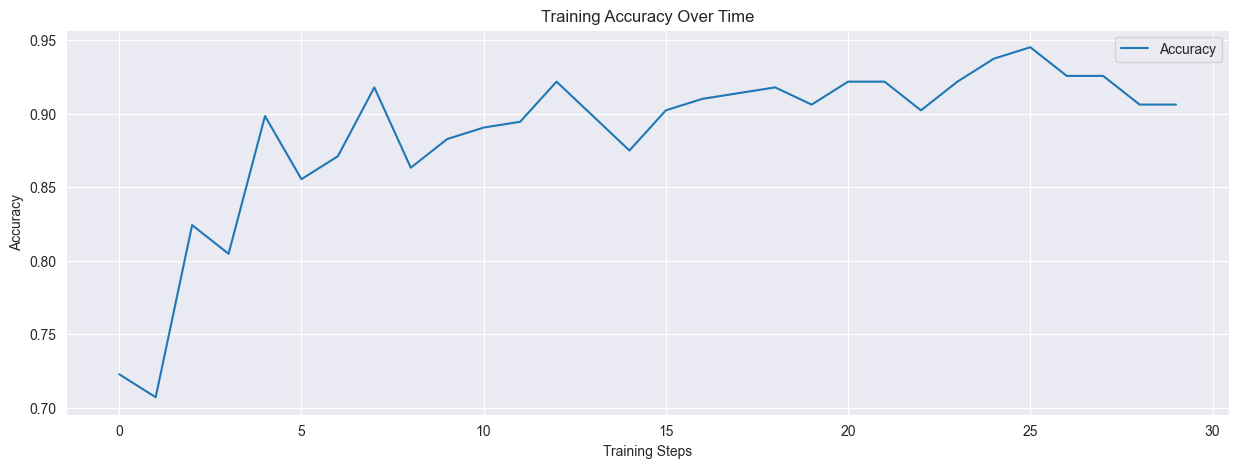

In [8]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

# Виведіть графік функції втрат
plt.figure(figsize=(15, 5))
plt.plot(loss_history, label='Loss')
plt.title('Training Loss Over Time')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Виведіть графік точності
plt.figure(figsize=(15, 5))
plt.plot(accuracy_history, label='Accuracy')
plt.title('Training Accuracy Over Time')
plt.xlabel('Training Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [9]:
# Обчисліть точність навченої нейромережі
train_predictions = neural_net(x_train)
train_accuracy = accuracy(train_predictions, y_train)
print(f"Training Accuracy: {train_accuracy.numpy()}")
# Тестування моделі на тестових даних
test_predictions = neural_net(x_test)
test_accuracy = accuracy(test_predictions, y_test)
print(f"Test Accuracy: {test_accuracy.numpy()}")

Training Accuracy: 0.923799991607666
Test Accuracy: 0.9043999910354614


Accuracy on sampled images: 0.9000
The neural network made 1 errors out of 10 images.


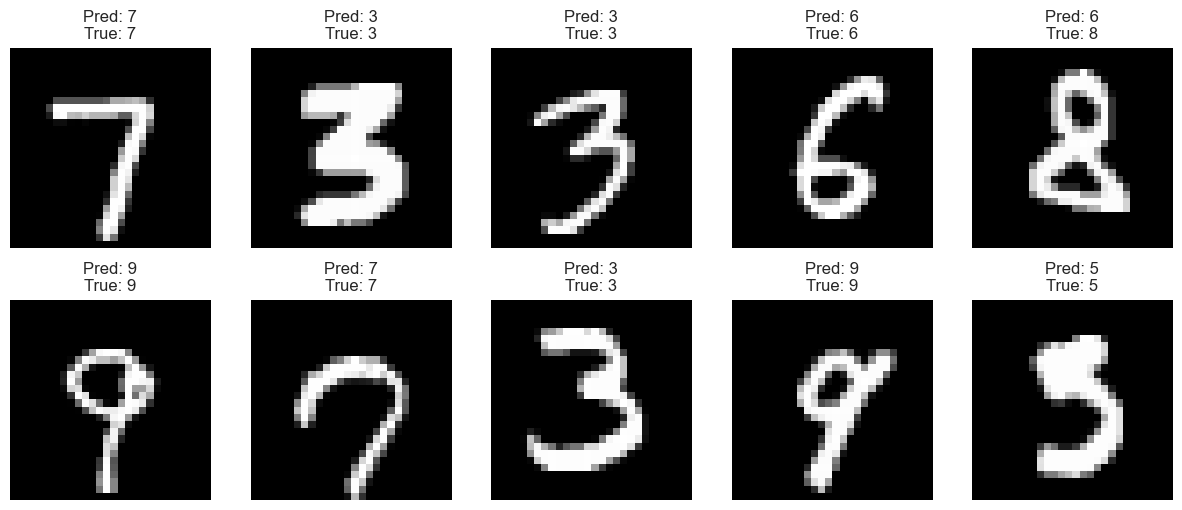

In [36]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

# Вибираєм 10 випадкових індексів з тестового набору даних
random_indices = np.random.choice(x_test.shape[0], 10, replace=False)

# Витягання вибраних зображень та міток
sample_images = x_test[random_indices]
sample_labels = y_test[random_indices]

# Отримання передбачення для вибраних зображень
predictions = neural_net(sample_images)

# Аналіз результатів передбачення
correct_predictions = np.equal(np.argmax(predictions, axis=1), sample_labels)
accuracy_sample = np.mean(correct_predictions)
print(f"Accuracy on sampled images: {accuracy_sample:.4f}")

# Підрахунок кількості помилок
correct_predictions = np.equal(np.argmax(predictions, axis=1), sample_labels)
error_count = np.sum(~correct_predictions)
print(f"The neural network made {error_count} errors out of 10 images.")
    
# Візуалізація зображень та вивід передбачень
plt.figure(figsize=(15, 6))
for i, image in enumerate(sample_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(np.reshape(image, (28, 28)), cmap='gray')
    predicted_label = np.argmax(predictions[i])
    plt.title(f"Pred: {predicted_label}\nTrue: {sample_labels[i]}")
    plt.axis('off')